In [1]:
%%javascript
$(document).ready(() => {
    // Удаление данного блока кода с конечного результата.
    $('div.code_cell').first().css('display', 'none');

    // Включение автоматического переноса слов в параграфе.
    $('div.text_cell p').css('hyphens', 'auto');

    // Включение растягивания текста на всю доступную длину.
    $('div.text_cell p').css('text-align', 'justify');
});

<IPython.core.display.Javascript object>

<h3><b>Лабораторная работа №4: Нейронные сети</b></h3>

<p lang="ru">Искусственная нейронная сеть — это система соединенных и взаимодействующих между собой простых процессоров. Такие процессоры обычно довольно просты. Каждый процессор подобной сети имеет дело только с сигналами, которые он периодически получает, и сигналами, которые он периодически посылает другим процессорам. Тем не менее, будучи соединёнными в достаточно большую сеть с управляемым взаимодействием, эти процессоры вместе способны выполнять довольно сложные задачи, поскольку нейронные сети обучаются в процессе работы.</p>

In [2]:
%autosave 300

Autosaving every 300 seconds


In [3]:
import warnings

# Игнорирование некоторых оповещающих сообщений библиотек.
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
import numpy as np
import pandas as pd

In [5]:
# Импортирование дополнительного алгоритма для оптимизации модели.
from scipy.optimize import fmin_cg

In [6]:
# Импортирование функции для чтения MATLAB файлов.
from scipy.io import loadmat

In [7]:
# Импортирование функции для разделения исходной выборки данных.
from sklearn.model_selection import train_test_split

In [8]:
# Импортирование библиотеки для работы с графиками.
from matplotlib import pyplot
%matplotlib inline

In [9]:
# Установка начального значения для генератора случайных чисел.
# Данное действие требуется для воспроизведения результатов опыта.
np.random.seed(0)

<p lang="ru"><b>Пункт №1:&nbsp;</b>Загрузка первого предоставленного набора данных <tt>ex4data1.mat</tt> при помощи внешней библиотеки scipy. Текущий набор данных содержит несколько тысяч изображений в оттенках серого. Каждый пиксель представляет собой значение яркости.</p>

In [10]:
data = loadmat('./datasets/ex4data1.mat')

In [11]:
data_x = np.array(data['X'])
data_y = np.array(data['y']).ravel()

<p lang="ru"><b>Пункт №2:&nbsp;</b>Загрузка первого предоставленного набора весовых коэффициентов <tt>ex4weights.mat</tt> при помощи внешней библиотеки scipy. Текущий набор весовых коэффициентов содержит натренированное индуцированное локальное поле полносвязной нейронной сети.</p>

In [12]:
weights = loadmat('./datasets/ex4weights.mat')

In [13]:
# Первая матрица весов имеет размер: 25 x 401.
theta0 = weights['Theta1']

# Вторая матрица весов имеет размер: 10 x 26.
theta1 = weights['Theta2']

In [14]:
# Преобразование всех весовых коэффициентов в общий вектор.
theta = np.r_[theta0.ravel(), theta1.ravel()]

<p lang="ru"><b>Пункт №3:&nbsp;</b>Реализация функции прямого расспространения сигнала для данной математической модели. Функция для прямого расспространения необходима для получения результатов классификации нейронной сети.</p>

In [15]:
def sigmoid(z):
    # Сигмоидальная функция активации.
    return np.power(1.0 + np.exp(-z), -1.0)

In [16]:
def forward_pass(w0, w1, x):
    # Добавление значений смещения.
    s = np.c_[(np.ones(x.shape[0]), x)]

    # Применение функции активации.
    s = sigmoid(w0.dot(s.T))

    # Добавление значений смещения.
    s = np.c_[(np.ones(s.shape[1]), s.T)]

    # Применение функции активации.
    s = sigmoid(w1.dot(s.T))

    # Вычисление результата прямого прохода сигнала в нейронной сети.
    return np.argmax(s, axis=0) + np.repeat(1, s.shape[1])

<p lang="ru"><b>Пункт №4:&nbsp;</b>Проведение замеров точности обученной модели на исходных данных по заранее известным значениям. Данное действие необходимо для предварительной оценки корректности математической модели к обобщению данных.</p>

In [17]:
# Вычисление точности обученной математической модели.
print('Значение точности:', np.mean(forward_pass(theta0, theta1, data_x) == data_y))

Значение точности: 0.9752


<p lang="ru"><b>Пункт №5:&nbsp;</b>Перекодирование исходных меток классов в унитарный код. Унитарный код — это двоичный код фиксированной длины, содержащий только однy прямой унитарный код или только один обратный унитарный код. Длина кода определяется количеством кодируемых объектов, то есть каждому объекту соответствует отдельный разряд кода, а значение кода положением один или ноль в кодовом слове.</p>

In [18]:
data_y = pd.get_dummies(data_y.ravel()).values

<p lang="ru"><b>Пункт №6:&nbsp;</b>Реализация функции стоимости модели для набора данных <tt>ex4data1.mat</tt> при помощи внешней библиотеки numpy. Данная функция выражает меру количества ошибок, которые рассматриваемая модель делает на наборе данных. Хоть и существуют различные функции стоимости, все они вычисляют расстояние между предсказанным и фактическим значением.</p>

In [19]:
num_labels = 10
num_inputs = 400  # Изображение имеет размер 20 x 20 и разворачивается в вектор из 400 признаков.
num_hidden = 25   # Количество нейронов скрытого слоя искусственной нейронной сети.

In [20]:
def calc_cost(w, x, y, l2=0.0, eps=1e-6):
    # Создание первой матрицы с параметрами модели из общего вектора коэффициентов.
    w0 = w[:num_hidden*(num_inputs+1)].reshape(num_hidden, num_inputs+1)

    # Создание второй матрицы с параметрами модели из общего вектора коэффициентов.
    w1 = w[num_hidden*(num_inputs+1):].reshape(num_labels, num_hidden+1)

    # Добавление значений смещения.
    s = np.c_[(np.ones(x.shape[0]), x)]

    # Применение функции активации.
    s = sigmoid(w0.dot(s.T))

    # Добавление значений смещения.
    s = np.c_[(np.ones(s.shape[1]), s.T)]

    # Применение функции активации.
    s = sigmoid(w1.dot(s.T))

    # Вычисление значения функции стоимости.
    cost = -np.sum(y * np.log(s.T) + (1 - y) * np.log(1 - s + eps).T) / x.shape[0]

    # Вычисление значения суммы регуляризационных параметров.
    reg_sum = np.sum(np.square(w0[:, 1:])) + np.sum(np.square(w1[:, 1:]))

    # Вычисление значения стоимости модели с учетом регуляризации.
    return cost + l2 / ( 2 * x.shape[0]) * reg_sum

In [21]:
# Вычисление значения стоимости обученной математической модели.
print('Значение стоимости:', calc_cost(theta, data_x, data_y))

Значение стоимости: 0.28762001166726947


<p lang="ru"><b>Пункт №7:&nbsp;</b>Реализация функции вычисления градиента функции стоимости для данной математической модели. Данная функция необходима для корректировки параметров исходной модели методом обратного расспространения ошибки. Обратное распространение ошибки — это способ обучения нейронной сети. Цели обратного распространения просты — отрегулировать каждый вес пропорционально тому, насколько он способствует общей ошибке. Если итеративно уменьшать ошибку каждого веса, в конце концов будет ряд весов, которые дают хорошие прогнозы.</p>

In [22]:
def sigmoid_grad(z):
    # Вычисление градиента сигмоидальной функции.
    return sigmoid(z) * (1 - sigmoid(z))

In [23]:
def calc_grad(w, x, y, l2=0.0):
    # Создание первой матрицы с параметрами модели из общего вектора коэффициентов.
    w0 = w[:num_hidden*(num_inputs+1)].reshape(num_hidden, num_inputs+1)

    # Создание второй матрицы с параметрами модели из общего вектора коэффициентов.
    w1 = w[num_hidden*(num_inputs+1):].reshape(num_labels, num_hidden+1)

    # Добавление значений смещения.
    s0 = np.c_[(np.ones(x.shape[0]), x)]

    # Применение функции активации.
    s1 = sigmoid(w0.dot(s0.T))

    # Добавление значений смещения.
    s2 = np.c_[(np.ones(s1.shape[1]), s1.T)]

    # Применение функции активации.
    s3 = sigmoid(w1.dot(s2.T))

    # Вычисление значений стоимостей слоев математической модели.
    delta1 = s3 - y.T
    delta0 = w1.T[1:, :].dot(delta1) * sigmoid_grad(w0.dot(s0.T))

    # Вычисление значений градиентов параметров.
    grad1 = delta1.dot(s2) / x.shape[0]
    grad0 = delta0.dot(s0) / x.shape[0]

    return np.r_[grad0.ravel(), grad1.ravel()]

<p lang="ru"><b>Пункт №8:&nbsp;</b>Реализация функции вычисления значения градиента при помощи численного метода. Нейронная сеть по существу является многомерной функцией, где коэффициенты или параметры функций необходимо найти или обучить. Из определения первой производной мы можем аппроксимировать градиент функции, тем самым проверить вычисление основной функции градиента на корректность работы.</p>

In [24]:
def calc_num_grad(w, x, y, l2=0.0, eps=1e-4):
    h = np.zeros((w.shape[0], w.shape[0]))

    # Заполнение матрицы для вычисления погрешности.
    np.fill_diagonal(h, eps)

    loss0 = np.zeros(w.shape)
    loss1 = np.zeros(w.shape)

    # Вычисление значений стоимости модели с учетом погрешности.
    for i in range(w.shape[0]):
        loss0[i] = calc_cost(w - h[i], x, y)
        loss1[i] = calc_cost(w + h[i], x, y)

    # Вычисление значения градиента численным методом.
    return (loss1 - loss0) / (2 * eps)

In [25]:
%%time

# Вычисление градиента основной функцией.
grad0 = calc_grad(theta, data_x[0:30], data_y[0:30])

# Вычисление градиента численным методом.
grad1 = calc_num_grad(theta, data_x[0:30], data_y[0:30])

CPU times: user 18 s, sys: 3.03 s, total: 21 s
Wall time: 25.7 s


In [26]:
# Вычисление значений разницы градиентов модели.
print('Проверка градиента:', np.linalg.norm(grad0 - grad1) / np.linalg.norm(grad0 + grad1))

Проверка градиента: 2.9148286413566776e-07


<p lang="ru"><b>Пункт №9:&nbsp;</b>Реализация функции инициализации параметров математической модели небольшими начальными значениями. Принцип выбора начальных значений весов для слоев, составляющих модель очень важен так как установка всех весов в ноль будет серьезным препятствием для обучения, так как ни один из весов изначально не будет активен. Даже если задача не предполагает такой крайности, удачно выбранный способ инициализации весов может значительно влиять на способность модели к обучению.</p>

In [27]:
def init_theta(layer_in, layer_out):
    # Вычисление порогового значения для инициализации параметров модели.
    eps = np.sqrt(6) / np.sqrt(layer_in + layer_out)

    # Инициализация параметров модели равномерным распределением.
    return np.random.uniform(-eps, eps, size=(layer_out, layer_in))

In [28]:
theta0 = init_theta(num_hidden, num_inputs+1)
theta1 = init_theta(num_labels, num_hidden+1)

In [29]:
# Преобразование всех весовых коэффициентов в общий вектор.
thetas = np.r_[theta0.ravel(), theta1.ravel()]

In [30]:
# Создание тренировочной и контрольной выборки данных.
x_train, x_tests, y_train, y_tests = train_test_split(data_x, data_y)

In [31]:
%%time

# Запуск оптимизации математической модели.
params = fmin_cg(f=calc_cost, x0=thetas, fprime=calc_grad, args=(x_train, y_train, 0.1), disp=0)

CPU times: user 34.1 s, sys: 3.81 s, total: 37.9 s
Wall time: 29.2 s


In [32]:
# Вычисление значения стоимости обученной математической модели.
print('Значение стоимости:', calc_cost(params, x_train, y_train, 0.1))

Значение стоимости: 0.1345218501541469


<p lang="ru"><b>Пункт №10:&nbsp;</b>Визуализация скрытого слоя обученной математической модели. Данное действие необходимо для визуальной оценки корректности обучения математической модели. После построения графика скрытого слоя математической модели можно заметить очертания объектов, что говорит о корректном протекании обучения модели.</p>

In [33]:
# Создание первой матрицы с параметрами модели из общего вектора коэффициентов.
theta0 = params[:num_hidden*(num_inputs+1)].reshape(num_hidden, num_inputs+1)

# Создание второй матрицы с параметрами модели из общего вектора коэффициентов.
theta1 = params[num_hidden*(num_inputs+1):].reshape(num_labels, num_hidden+1)

In [34]:
images = [
    # Вырезание нескольких объектов из скрытого слоя.
    theta0[i:i+5, :-1].reshape(-1, 20).T
    for i in range(num_hidden // 5)
]

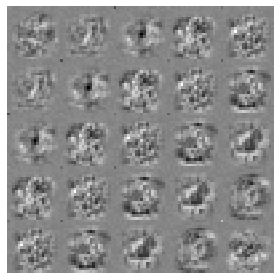

In [35]:
# Визуализация скрытого слоя обученной математической модели.
pyplot.imshow(np.array(images).reshape(-1, 100), cmap='gray')

# Отключение координатных осей.
pyplot.axis('off')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

<p lang="ru"><b>Пункт №11:&nbsp;</b>Вычисление процента правильных классификаций математической модели на обучающей выборке. Точность предсказания часто оценивают как отношение количества верно определенных классов к общему количеству предсказаний. Данное действие необходимо для визуальной оценки корректности математической модели к обобщению данных.</p>

In [36]:
# Перекодирование исходных меток классов из унитарного кода.
y_tests = np.argmax(y_tests, axis=1) + np.repeat(1, y_tests.shape[0])

In [37]:
# Вычисление точности обученной математической модели.
print('Значение точности:', np.mean(forward_pass(theta0, theta1, x_tests) == y_tests))

Значение точности: 0.924
